In [1]:
import sqlite3
import os
from pandas.io import sql
import tables
import re
import pysam
import matplotlib
import matplotlib.image as mpimg
import seaborn
import matplotlib.pyplot as plt
import numpy
import random
import pandas
import statsmodels
%matplotlib inline
import keras
from keras import backend
backend._BACKEND="theano"

Using TensorFlow backend.


In [2]:
def Vectorize_sequence(seq):
    # the order of the letters is not arbitrary.
    # Flip the matrix up-down and left-right for reverse compliment
    ltrdict = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1], 'N':[0,0,0,0]}
    return numpy.array([ltrdict[x] for x in seq])

def Vector_to_nuc(arr):
    sequence = ''
    #print arr
    for i in range(len(arr)):
        if arr[i,0] == 1:
            sequence = sequence + 'A'
        if arr[i,1] == 1:
            sequence = sequence + 'C'
        if arr[i,2] == 1:
            sequence = sequence + 'G'
        if arr[i,3] == 1:
            sequence = sequence + 'T'
    return sequence

def Predict_arf_binding_to_sequence(sequence,sequence_label,list_of_arfs):
    
    if sequence<201:
        return None
    
    number_of_sub_seqs = len(sequence)-201
    binding_score_by_position = [0]*number_of_sub_seqs*len(list_of_arfs)
    arf_labels = [' ']*number_of_sub_seqs*len(list_of_arfs)
    position = [0]*number_of_sub_seqs*len(list_of_arfs)
    seq_label = [sequence_label]*number_of_sub_seqs*len(list_of_arfs)
    total_binding_score = [0]*len(list_of_arfs)

    
    
    counter1=0
    counter2=0
    for arf_label in list_of_arfs:
        model = keras.models.load_model('/mnt/Data_DapSeq_Maize/TrainedModel_DanQ_' +arf_label+'.h5')
        
        test_seqs = numpy.empty([number_of_sub_seqs,201,4])
        
        start=counter1
        for i in range(number_of_sub_seqs):
            test_seqs[i] = Vectorize_sequence(sequence[i:(i+201)])
            arf_labels[counter1] = arf_label
            position[counter1] = i
            counter1 = counter1+1
        end=counter1
        
        binding_score_by_position[start:end] = model.predict(test_seqs).flatten()         
        total_binding_score[counter2] = sum(binding_score_by_position)
        counter2=counter2+1
            
    relative_binding = pandas.DataFrame({'sequence_label':seq_label,'binding_score_by_position':binding_score_by_position,'arf_labels':arf_labels,'position':position})
    total_binding = pandas.DataFrame({'sequence_label':sequence_label*len(total_binding_score),'total_binding_score':total_binding_score,'arf_labels':list_of_arfs})
    
    return relative_binding,total_binding

def Calculate_relative_arf_binding_for_list_of_sequences(list_of_sequences,sequence_labels,list_of_arfs,save_path_positional,save_path_total):
    
    relative_positional_arf_binding = pandas.DataFrame({'sequence_label':[None],'binding_score_by_position':[None],'arf_labels':[None],'position':[None]})
    relative_total_arf_binding = pandas.DataFrame({'sequence_label':[None],'total_binding_score':[None],'arf_labels':[None]})
    
    counter1=0
    for sequence in list_of_sequences:
        x,y = Predict_arf_binding_to_sequence(sequence,sequence_labels[counter1],list_of_arfs)
        relative_positional_arf_binding = relative_positional_arf_binding.append(x,ignore_index=True)
        relative_total_arf_binding = relative_total_arf_binding.append(y,ignore_index=True)
        counter1=counter1+1
    
    relative_positional_arf_binding.to_pickle(save_path_positional)
    relative_total_arf_binding.to_pickle(save_path_total)    

    return

def Plot_relative_arf_binding_for_list_of_sequences(list_of_sequences,relative_positional_arf_binding,relative_total_arf_binding,save_path):
    
    f, ax = plt.subplots(len(list_of_sequences), 2, figsize=(15,15))
    counter1=0
    for counter1 in range(len(list_of_sequences)):
        seaborn.lmplot(data=relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==counter1], ax=ax[counter1,0],x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True)
        plt.xticks(numpy.arange(min(relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==counter1]['position']), max(relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==counter1]['position'])+1, 1000.0))
        seaborn.barplot(data=relative_total_arf_binding[relative_total_arf_binding['sequence_label']==counter1],ax=ax[counter1,1],x='arf_labels',y='total_binding_score',palette='YlOrRd')
        counter1=counter1+1
    plt.savefig(save_path)

In [18]:
# list_of_arfs = ['ARF4','ARF10','ARF13','ARF16','ARF18','ARF27','ARF29','ARF34','ARF35','ARF39']
# list_of_sequences = ['TGTGAAAATTTTAAGGTGTGAATGCGACGTTTGAATTTTAAGGTACAACTTCTAAGCTGGGACCACAAATAATTCTAGCTATACCGTTGCACACAAATTATCATATTATCATTCTTAATCATTTTCAATAAAAATTCAATTAATTTTGTGAAAATTTTATGGTGTGAACACGATGTTTTAATTTTAAGGTTCGGCTTCTAAAGTGGGACCCATAGATGAATCTAGCTACAATGTTGCAAACAAATTAGCATATTATTATTCTTACTTATTTCAAAAAAAAAATCAATTAAGTTTGTGAAAATTTAAGGTGTGAACACAACAGTTTAATTTTAAGGTCCGAATTATAAAGTCGGACCCCCATATGAATATAGCTACACCATTGAACACAAATTAGTATATTATTATTCTTACTTATTTCCAAAAAAATAGTAATTAATTTTGTGAAAATTTTGAGGTGTAAACACAACGTTTTAAATTTTAAGGTACGTCTTCTAAGGTGGGACCCATGTATGAATTGCACATAATTTAGCAGATGATTATTGTTACTAGTTTCTAAAAAATAAATTAATTTTATGAGAATTTTAAAGTTAGAACTTTGGTAGTGAATCTACCCTAGTGAACATGGATTTTCAGGGGTATTCCATGTGTTTAGGTAATGGGTTTAACCCAGTAGCTATGGGTGGATTTAGGTGGGTTATTTAGTTTAATTATTATATGGTGGGTTTGGTTGAAGAAAATAACTCATTTGTAGGGTTTGGGTGGGTTTGACCCTAATAGCAGGGCTAACAACATGACGCTTCCATGCTGCCGAAGAGCTTCTTCGCATATTCAAGCTCCTCCGCGCCCGCATATTCAAGCTTCTCCGTGCCGCCGCCGCCGCAGATTTCCTCCATGGCGCCGGCCGAGCTCCTCTGCCCTGGTGGTTCTCCTGACCGGTCGAGCTCCTCCGCGCCGCCGCAGCTGAGGGCCTCCACGTCACCCCTGGTGGCCATCGCAGCTTCTGTCGCGACGAGGAGGGGATATAGCGGATGAACAGTGAATTGAATCGCCAGCTTCAGAGTATACTGTTAATTTAATCGCCATATATGCTCGTAACAACCCGCTTTTATGAGTAGCCACATATATATAATGTTGAAGAGAATCGGTGCCTAGCTAGCTAGCCATATATGTAGAGTATTATTATATAGCCACTTTGATTTAAAATAATGTTCTGGTTTAAGATTTATTTATCATAGTGTCATAGAAAATCACTATCGAGAGAATTGAGGGAGTGGTGAGCTCTCCAACAATATAATATAGCTGCTATGCTATGCTATAATACGTATACGTAGCCACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTTTTTTCATGCACACAAACGTGTCGTATCTGATCAATAATCACACGAGACAGAGACTCTGCCTAGCTTGACATCGATGGGCAACGAACATCATGCATGTGCGCTCGTGGAGTAGCTTTCTTTCTTTCTTTATGTCCTCTGTACTGTACGTGTGCGTACATGCACGGTCGATCGATGCAATAATTAATTAATTAATTAATTATCATAATATGAGCGCGGACACAGAGTAAATCCAAGCTGCCGCTGTCACCACCACACACCTCGAATCTCACTGTTGGTTCCTTGCTTCTTGTTGTGTTTTGTACATATAGTCTGTGAGAGCTAGCTGAGGAATACGATAGATGGTTACGGGACCAAACGCAGCATATTCCGACAACTTAACACGTCATTGCATGTGATGGAGGGACCGATCGACGACGACGACATGGCCCGGCCGGGTCACATCATATTATTGCTTGGACCACACAATAATATTATTTATTTGTTGCATATATATTATTGTTTGGTGGACCACACAGATCTAACGTGCACGAACCTGCCAGTATTATTTATTTGTTTAGGCGCCCTATTGGATGAATCCACCAACCAACACACTAGGCTCCAACAGAGAGCAACGTACGGTTGGGATCTTATTTAGGATGGGGTGAGTACATTGTTTAGTAGCCACAAATAGTATGTCTCAGTACGTCTTGGTGGTGTGTCATATCCACGCACCGTTCGTTCACGCATTATTTTTTTTCCCAATCGTTACCTACCACGCGCGCATGCTGTCTCGATATTCACGAGAGTGTGGACGGTGGACCATGCATGCGTACATGTCGGAGTGCATGTAGATATCGTCGTGTTCGTGCATGTCTGGGCATTGATTTTTTTTTTTTGTATTGCTAACCAATCGGTGTTGGAATAATTAGCCTGCCTAGGGTAATATATATAATATAATGTCAAGTCGACAAACATGCATGGCCTTGCAGTGGCCGTGGGGCCGGCCTATATCACGTGTACCCCGGCCGAAAGCCCATTTCATATCGTACGTACCCTAGCTAGTGCAACGTTCCTGCTACTCTGCAGCTAGTCATCTCTAGCTACCATGCATGCTGAGAGAGAACAAAAAAAGTTTTACGGACGTACGTGCATAATTGCATAATATATAATCATCTGACAACGTCTCAGCTAGGTGCATGTGCGACAACCTGCTTGTCTAATTCCTAGCTACTTTGTAGCATATATATGCAGAGAAAAAGTTTGATGCGTGACAGTTTTCGAATCTGTGATGACATGTAAAACAAAAACCTCCCTCCCTCCCTCCATAATTACATTTCACTGTACCATATATTGGTCATTCGATGCATTATATTATTACCTAACGTGTCATATATACAGGTTAATTAATTATATAGCCTTTGTATTCCATGGTTAATTCGCCGACGCCACATATTTCCAAAATCGAATAGAGAAATGGACGTGCATATACAACAACCCTGTCTAATCTCTATTATTACGAAGCAACAGTTGTATCAACTTGTTAAGCATATAGGCTCGATGGCGGAGAGGCAAACGGAGAAAAAGGCCATACAAATATATATGTGCTCCGGTGCAACTAAAGAGCGTGGGATCAACAATTCCATACAAAAAGACTAGCTATATTGTGCACCGAAAGCTAGCTAAAGCGAAAACGACGCGTCTTTTAATTCTAGCTAGACAAAAGGCAATACAAATAATGTCGCATTTGTACACGTCGTAATCTCTCTCGTTTTCTTGCGTACTTTAATTGTACCTTTCGCTTTTCTAGCGTCGGGAGTGTGCTTTCATTCCCTCGACCCTTGGCCATCACCGAGGGTCAGAGAGCAACAACAGCCTAGATCCACATGCTACATATACACTTGTAATCCTATTACTTTTTTTTCTTTCTTTCAGAAAACTAATTTTCATATCATGTTTGTCCATTAGAGAACATAGACTTTAACTTATATATACATGCACACCAGTGTCCATTAGAGATAGTTATGTGAGGGCTAAGACCATCTCCAACCCATAAACTACATAGTTTCTATGTGCTTTATTAATTAATGTACAAACTAAGCAAAACTGAGAACATATGTCACTGTAATTAAGGAAGAGAGGGAGAGGGAGACAAAATGAATTAAATGGTCCCTTGTCCAAGAAACCATATCTTCACAAAAATAATATATGAAGAGATCTAGTGGGTAGATGATAGGCGAGAGAGAGAGAAAGTTGTGATGAAATAGACTCATAGTTATCGTTGGGTCTCTCTACGGACGTACGTGCTACAATGTTTTTGCACAGGACCTGATGTAAGTAGGGGCGCCATTGGCATTGTTGCATAGAGCAGGGTGTACTGCGACAGGGCACATGCATGCCCCAAATGATTATTAG', 'TGGTGTGAACATGATGTTTTAATTTTAAGGTTCGACTTCTAAAGTGGGACCCATAGATGAATCTAGCTACAATGTTGCAAACAAATTAGCATATTATTATTATTACTTATTTCAAAAAAAAAATCAATTAAGTTTGTGAAAATTTAAGGTGTGAACACAACAGTTTAATTTTAAGGTCCGAATTATAAAGTCGGACCCCCATATGAATATAGCTACACCATTGAACACAAATTAGTATATTATTATTCTTACTTATTTCCAAAAAAATAGTAATTAATTTTGTGAAAATTTTGAGGTGTAAACACAACGTTTTAAATTTTAAGGTACGTCTTCTAAGGTGGGACCCATGTATGAATTGCACATAATTTAGCAGATGATTATTGTTACTAGTTTCTAAAAAATAAATTAATTTTATGAGAATTTTAAAGTTAGAACTTTGGTAGTGAATCTACCCTAGTGAACATGGATTTTCAGGGGTATTCCATGTGTTTAGGTAATGGGTTTAACCCAGTAGCTATGGGTGGATTTAGGTGGGTTATTTAGTTTAATTATTATATGGTGGGTTTGGTTGAAGAAAATAACTCATTTGTAGGGTTTGGGTGGGTTTGACCCTAATAGCAGGGCTAACAACATGACGCTTCCATGCTGCCGAAGAGCTTCTTCGCATATTCAAGCTCCTCCGCGCCCGCATATTCAAGCTTCTCCGTGCCGCCGCCGCCGTCCGAGCTCCTCTGCCCTGGTGGTTCTCCTGACCGGTCGAGCTCCTCCGCGCCGCCGCAGCTGAGGGCCTCCACGTCACCCCTGGTGGCCATCGCAGCTTCTGTCGCGACGAGGAGGGGATATAGCGGATGAACAGTGAATTGAATCGCCAGCTTCAGAGTATACTGTTAATTTAATCGCCATATATGCTCGTAACAACCCGCTTTTATGAGTAGCCACATATATATAATGTTGAAGAGAATCGGTGCCTAGCTAGCTAGCCATATATGTAGAGTATTATTATATAGCCACTTTGATTTAAAATAATGTTCTGGTTTAAGATTTATTTATCATAGTGTCATAGAAAATCACTATCGAGAGAATTGAGGGAGTGGTGAGCTCTCCAACAATATAATATAGCTGCTATGCTATGCTATAATACGTATACGTAGCCACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTTTTTTCATGCACACAAACGTGTCGTATCTGATCAATAATCACACGAGACAGAGACTCTGCCTAGCTTGACATCGATGGGCAACGAACNTCATGCATGTGCGCTCGTGGAGTAGCTTTCTTTCTTTCTNTATGTCCTCTGTACTGTACGTGTGCGTACATGCACGGTCGATCGATGCAATAATTAATTAATTAATTAATTATCATAATATGAGCGNGGACACAGAGTAAATCCAAGCTGCCGCTGTCACCACCACACACCTCGAATCTCACTGTTGGTTCCTTGCTTCTTGTTGTGTTTTGTACATATAGTCTGTGAGAGCTAGCTGAGGAATACGATAGATGGTTACGGGACCAAACGCAGCATATTCCGACAACTTAACACGTCATTGCATGTGATGGAGGGACCGATCGACGACGACGACATGGCCCGGCCGGGTCACATCATATTATTGCTTGGACCACACAATAATATTATTTATTTGTTGCATATATATTATTGTTTGGTGGACCACACAGATCTAACGTGCACGAACCTGCCAGTATTATTTATTTGTTTAGGCGCCCTATTGGATGAATCCACCAACCAACACACTAGGCTCCAACAGAGAGCAACGTACGGTTGGGATCTTATTTAGGATGGGGTGAGTACATTGTTTAGTAGCCACAAATAGTATGTCTCAGTACGTCTTGGTGGTGTGTCATATCCACGCACCGTTCGTTCACGCATTATTTTTTTTCCCAATCGTTACCTACCACGCGCGCATGCTGTCTCGATATTCACGAGAGTGTGGACGGTGGACCATGCATGCGTACATGTCGGAGTGCATGTAGATATCGTCGTGTTCGTGCATGTCTGGGCATTGATTTTTTTTTTTTGTATTGCTAACCAATCGGTGTTGGAATAATTAGCCTGCCTAGGGTAATATATATAATATAATGTCAAGTCGACAAACATGCATGGCCTTGCAGTGGCCGTGGGGCCGGCCTATATCACGTGTACCCCGGCCGAAAGCCCATTTCATATCGTACGTACCCTAGCTAGTGCAACGTTCCTGCTACTCTGCAGCTAGTCATCTCTAGCTACCATGCATGCTGAGAGAGAACAAAAAAAGTTTTACGGACGTACGTGCATAATTGCATAATATATGATCATCTGACAACGTCTCAGCTAGGTGCATGTGCGACAACCTGCTTGTCTAATTCCTAGCTACTTTGTAGCATATATATGCAGAGAAAAAGTTTGATGCGTGACAGTTTTCGAATCTGTGATGACATGTAAAACAAAAACCTCCCTCCCTCCCTCCATAATTACATTTCACTGTACCATATATTGGTCATTCGATGCATTATATTATTACCTAACGTGTCATATATACAGGTTGATTAATTATATATATAGCCTTTGTATTCCATGGTTAATTCGCCGACACCACATATTTCCAAAATCGAAGAGAGAAATGGACATGCATATACAACAACCCTGTCTAATCTCTATTATTAGAGAAGCAACAGTTGTATCAACTTGTTAAGCATATAGGCTCGATGGCGGAGAGGCAAACGGAGAAAAAGGCCATACAAATATATATGTGCTCCGGTGCAACTAAAGAGCGTGGGATCAACAATTCCATACAAAAAGACTAGCTATATTGTGCACCGAAAGCTAGCTAAAGCGAAAACGACGCGTCTTTTAATTCTAGCTAGACAAAAGGCCATACAAATAATGTCGCATTTGTACACGTCGTAATCTCTCTCGTTTTCTTGCGTACTTTAATTGTACCCTTCGCTTTTCTAGCGTCGGGAGTGTGCTTTCATTCCCTCGACCCTTGGGCATCACCGAGGGTCAGAGAGCAACAACAGCCTAGATCCACATGCTACATATACACTTGTAATCCTATTACTTTTTTTCTTTCTTTCAGAAAACTAATTTTCATATCATGTTTGTCCATTAGAGAACATAGACTTTAACTTATATATACATGCACACCAGTGTCCATTAGAGATAGTTATGTGAGGGCTAAGACCATCTCCAACCCATAAACTACATAGTTTCTATGTGCTTTATTAATTAATGTACAAACTAAGCAAAACTGAGAACATATGTCACTGTAATTAAGGAAGAGAGGGAGAGGGAGACAAAATGAATTAAATGGTCCCTTGTCCAAGAAACCATATCTTCACAAAAATAATATATGAAGAGATCTAGTGGGTAGATGATAGGCGAGAGAGAGAGAAAGTTGTGATGAAATAGACTCATAGTTATCGTTGGGTCTCTCTACGGACGTACGTGCTACAATGTTTTTGCACAGGACCTGATGTAAGTAGGGGCGCCATTGGCATTGTTGCATAGAGCAGGGTGTACTGCGACAGGGCACATGCATGCCCCAAATGATTATTAGTATAATTTTAAGGTCGGGCTTCTAAGGTGGGACCCGCAGATGAATCTTGCTACATCGTTGCACACAAACTAGTATATTATCATTCTTACTCATTTCCAAAAAAAATTAATTAATTTTGTGAAAATTTTGAGGCGTGAATGCGATGTTTTAATTTTAAGGTACAACTTCAAAGGTGGGACCACATATGAATCTATCTATACCGTTGCACACAGATTAGCGAATTATCATTCTTAATTAATCATTTCCAATAAAAATTCGATTAATTTTGTGGAAATTTTATGGTGTGAACGTGATGTTTTAATTTTAAGGTTCGACTTCTAAAGTGGGACCCATAGATGAATCTAGCTACAATGTTGCACATAAATTAGCAGATTATCATTCTTACTTATTTCAAAAAAATCAACTAATTTTGTGAAAATTTAAGGTATGAACACGACGGTTTAATTTTAAGGTCCGAATTCTAAGGTGGGACCCATATATGAATATAGCAACACTGCTGCACACAAATTAGCATATTATTATTCTTATTTATTTCCCCCTGTACCATATATTGGTCATAGAAAAAGTCACCCCTGGTGGCTAATTAATTTTGTGAAAATGTTGAGTGTGAACACGACATGTTTAATTTTTAGATCCGCCTTCTAAGGTGGGACCCACGTATGAATTGGACATAAATTAGCAGATGGTCATTCTTACTCGTTTCTAAAAAAACAATTAATTTTATGAAAAATTTAAAGTTAGAACTTGGTAGCGAGTCCACTCTAGTGAACATGAATCATTGAGGGAATGGTGAGAATTATATGTAGAGTATTATTCTATAGGCACTTTGATTTAAAAATGATGTTCTGGTTTAAGATTTATCATACTAGTGTGTTATAGCAAACCACTTAATTAATTAGGAGAGAGTTATAGCAATTAATCTTGTAACTTTAGAAGTAATCTGCCTAGAATTAAATGAGCTATAGTAGGGAATGGTGAGCTCTCCAACAGTATAATATATAGCTGCTGTGCTATAATAATACGTATAGGTAGCCACACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTATGAAATTTTATGAAATTTTTAAAGTTAGAACTTGGTAGCGAATCCACTCTAGTGGACATGAATCATTGAGGGAATGGTGGGAATTATATGTAGAGTATTATTATATAGCCACTTTGATTTAAAAATAATGTTCCGGTTTAAGATTTATCATACTAATTGACAGTTATAGCAAACCACTTAATTAATTGGGAGAGAGTTATAGCAATTAATCTTGTAACTTTAGAAGTAATCTGCCGAGAATTAAATGAGCTATATATAGTAGGGAATGGTGAGCTCTCCAACAGTATAATATAGCTGCTGTGCTATAATAATACGTATAGGTAGCCACACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTTTTTCATGCACAGTATTATTTGCTCCGTGCACTGTACAATCGCGTGTCGTATCTGATCAATAATCACGAGACAGAGACTGCCTTGATATCGATGGCAACGAACATCATGTGCCCTCCAAGCTGCCGCTGTCACCACCACACACACCTCGAATCTCACTGTTGGTTCCTTGCTTCTTGTTGTGTTTTGTATATAGTCTGTGAGCTAGCTGGGGAATACGATATATGGATGGTTACGGAACCAAACGCAGCATATTCCGACAACTTAACACGTCATTGCATGTGATGGAGGGACCGATCGACGACGACATGCATGGCCCGGCCGGGTCACATCATATTATTGCTTGGACCACACAATAATATTATTTATTTGTTGCATATATATTATTGTTTGGTGGACCGCCACACAGATCTAACGTGCACGAACCTGCCAATATTATTTATTTGTTTAGGCGCTATTTGATGAATCCACCAACCAACACTAGTATAGGCTCCAACAGAGACGACAGAGAGCAACGTACGGTTGGGACCTTATTTAGGATGGGGTGAGTACATTGTTTAGTAGCCACAAATAGTATGTTCATATCCACGCATTATTTTTCCCAATCGTTACCTACCACGCGCGCATGCTGTCTCGATATTCACGAGAGTGTGGACGGTGGACCATGCATGCGTAGTACATATCGGGGTGCAGATACGTCGTGTTCGTGCATGTCTGGGCATTGATTTTTTTTTTTGTATTGCTAACCAATCGGTGTTGGAATAATTAGCCTGCCTAGGGTAATATATATAATAATGTCAAGTCGACAAACATGCATGGCGTTGCAGTGGCGGTGGGGCCGGCCTATATCACGTGTACCCCGAAAGCCCATTTCATATCGTACGTACCCTAGCTAGTGCAACGTTCCTGCTACTCTGCAGCTAGTCATCTCTAGCTACCATGCATGCTGAGAGAGAGAAAAAGTTTTACGTACGTGCATAATTGCATAATATATAATCATCTGATAACGTCTCAGAGGTGCATGTGCGAGAAAACCTTGTCTAATTCCTAGCTACTTTGTACCATATATATATGCAGAGAAAAAGTTTGATGCGTGACAGTTTTCGAATCTGTGATGACATGTAAAACAAAAACCTCCCTCCCTCCCTCCATAATTACATTTCACTGTACCATATATTGGTCATTCGATGCATTATATTATTACCTAACGTGTCATATATACAGGTTGATTAATTATATATATAGCCTTTGTATTCCATGGTTAATTCGCCGACACCACATATTTCCAAAATCGAAGAGAGAAATGGACGTGCATATACAACAACCCTGTCTAATCTCTATTATTAGAGAAGCAACAGTTGTATCAACTTGTTAAGCATATAGGCTCGATGGCGGAGAGGCAAACGGAGAAAAAGGCCATACAAATATATATGTGCTCCGGTGCAACTAAAGAGCGTGGGATCAACAATTCCATACAAAAAGACTAGCTATATTGTGCACCGAAAGCTAGCTAAAGCGAAAACGACGCGTCTTTTAATTCTAGCTAGACAAAAGGCCATACAAATAATGTCGCATTTGTACACGTCGTAATCTCTCTCGTTTTCTTGCGTACTTTAATTGTACCCTTCGCTTTTCTAGCGTCGGGAGTGTGCTTTCATTCCCTCGACCCTTGGGCATCACCGAGGGTCAGAG']
# save_path = '/mnt/Data_DapSeq_Maize/170607_SNP_Relative_ARF_binding_analysis.svg'

# # Calculate_relative_arf_binding_for_list_of_sequences(list_of_sequences,list_of_arfs,save_path_positional,save_path_total)
# relative_positional_arf_binding = pandas.read_pickle('/mnt/Data_DapSeq_Maize/Herbivore_SNP_relative_positional_arf_binding.pkl')
# relative_total_arf_binding = pandas.read_pickle('/mnt/Data_DapSeq_Maize/Herbivore_SNP_relative_total_arf_binding.pkl')



In [3]:
#Doing analysis on the indeviual DICE elements with just the activator ARFs
list_of_arfs = ['ARF35','ARF18','ARF29','ARF34','ARF4','ARF16','ARF27','ARF10','ARF13']
list_of_sequences = ['TGTGAAAATTTTAAGGTGTGAATGCGACGTTTGAATTTTAAGGTACAACTTCTAAGCTGGGACCACAAATAATTCTAGCTATACCGTTGCACACAAATTATCATATTATCATTCTTAATCATTTTCAATAAAAATTCAATTAATTTTGTGAAAATTTTATGGTGTGAACACGATGTTTTAATTTTAAGGTTCGGCTTCTAAAGTGGGACCCATAGATGAATCTAGCTACAATGTTGCAAACAAATTAGCATATTATTATTCTTACTTATTTCAAAAAAAAAATCAATTAAGTTTGTGAAAATTTAAGGTGTGAACACAACAGTTTAATTTTAAGGTCCGAATTATAAAGTCGGACCCCCATATGAATATAGCTACACCATTGAACACAAATTAGTATATTATTATTCTTACTTATTTCCAAAAAAATAGTAATTAATTTTGTGAAAATTTTGAGGTGTAAACACAACGTTTTAAATTTTAAGGTACGTCTTCTAAGGTGGGACCCATGTATGAATTGCACATAATTTAGCAGATGATTATTGTTACTAGTTTCTAAAAAATAAATTAATTTTATGAGAATTTTAAAGTTAGAACTTTGGTAGTGAATCTACCCTAGTGAACATGGATTTTCAGGGGTATTCCATGTGTTTAGGTAATGGGTTTAACCCAGTAGCTATGGGTGGATTTAGGTGGGTTATTTAGTTTAATTATTATATGGTGGGTTTGGTTGAAGAAAATAACTCATTTGTAGGGTTTGGGTGGGTTTGACCCTAATAGCAGGGCTAACAACATGACGCTTCCATGCTGCCGAAGAGCTTCTTCGCATATTCAAGCTCCTCCGCGCCCGCATATTCAAGCTTCTCCGTGCCGCCGCCGCCGCAGATTTCCTCCATGGCGCCGGCCGAGCTCCTCTGCCCTGGTGGTTCTCCTGACCGGTCGAGCTCCTCCGCGCCGCCGCAGCTGAGGGCCTCCACGTCACCCCTGGTGGCCATCGCAGCTTCTGTCGCGACGAGGAGGGGATATAGCGGATGAACAGTGAATTGAATCGCCAGCTTCAGAGTATACTGTTAATTTAATCGCCATATATGCTCGTAACAACCCGCTTTTATGAGTAGCCACATATATATAATGTTGAAGAGAATCGGTGCCTAGCTAGCTAGCCATATATGTAGAGTATTATTATATAGCCACTTTGATTTAAAATAATGTTCTGGTTTAAGATTTATTTATCATAGTGTCATAGAAAATCACTATCGAGAGAATTGAGGGAGTGGTGAGCTCTCCAACAATATAATATAGCTGCTATGCTATGCTATAATACGTATACGTAGCCACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTTTTTTCATGCACACAAACGTGTCGTATCTGATCAATAATCACACGAGACAGAGACTCTGCCTAGCTTGACATCGATGGGCAACGAACATCATGCATGTGCGCTCGTGGAGTAGCTTTCTTTCTTTCTTTATGTCCTCTGTACTGTACGTGTGCGTACATGCACGGTCGATCGATGCAATAATTAATTAATTAATTAATTATCATAATATGAGCGCGGACACAGAGTAAATCCAAGCTGCCGCTGTCACCACCACACACCTCGAATCTCACTGTTGGTTCCTTGCTTCTTGTTGTGTTTTGTACATATAGTCTGTGAGAGCTAGCTGAGGAATACGATAGATGGTTACGGGACCAAACGCAGCATATTCCGACAACTTAACACGTCATTGCATGTGATGGAGGGACCGATCGACGACGACGACATGGCCCGGCCGGGTCACATCATATTATTGCTTGGACCACACAATAATATTATTTATTTGTTGCATATATATTATTGTTTGGTGGACCACACAGATCTAACGTGCACGAACCTGCCAGTATTATTTATTTGTTTAGGCGCCCTATTGGATGAATCCACCAACCAACACACTAGGCTCCAACAGAGAGCAACGTACGGTTGGGATCTTATTTAGGATGGGGTGAGTACATTGTTTAGTAGCCACAAATAGTATGTCTCAGTACGTCTTGGTGGTGTGTCATATCCACGCACCGTTCGTTCACGCATTATTTTTTTTCCCAATCGTTACCTACCACGCGCGCATGCTGTCTCGATATTCACGAGAGTGTGGACGGTGGACCATGCATGCGTACATGTCGGAGTGCATGTAGATATCGTCGTGTTCGTGCATGTCTGGGCATTGATTTTTTTTTTTTGTATTGCTAACCAATCGGTGTTGGAATAATTAGCCTGCCTAGGGTAATATATATAATATAATGTCAAGTCGACAAACATGCATGGCCTTGCAGTGGCCGTGGGGCCGGCCTATATCACGTGTACCCCGGCCGAAAGCCCATTTCATATCGTACGTACCCTAGCTAGTGCAACGTTCCTGCTACTCTGCAGCTAGTCATCTCTAGCTACCATGCATGCTGAGAGAGAACAAAAAAAGTTTTACGGACGTACGTGCATAATTGCATAATATATAATCATCTGACAACGTCTCAGCTAGGTGCATGTGCGACAACCTGCTTGTCTAATTCCTAGCTACTTTGTAGCATATATATGCAGAGAAAAAGTTTGATGCGTGACAGTTTTCGAATCTGTGATGACATGTAAAACAAAAACCTCCCTCCCTCCCTCCATAATTACATTTCACTGTACCATATATTGGTCATTCGATGCATTATATTATTACCTAACGTGTCATATATACAGGTTAATTAATTATATAGCCTTTGTATTCCATGGTTAATTCGCCGACGCCACATATTTCCAAAATCGAATAGAGAAATGGACGTGCATATACAACAACCCTGTCTAATCTCTATTATTACGAAGCAACAGTTGTATCAACTTGTTAAGCATATAGGCTCGATGGCGGAGAGGCAAACGGAGAAAAAGGCCATACAAATATATATGTGCTCCGGTGCAACTAAAGAGCGTGGGATCAACAATTCCATACAAAAAGACTAGCTATATTGTGCACCGAAAGCTAGCTAAAGCGAAAACGACGCGTCTTTTAATTCTAGCTAGACAAAAGGCAATACAAATAATGTCGCATTTGTACACGTCGTAATCTCTCTCGTTTTCTTGCGTACTTTAATTGTACCTTTCGCTTTTCTAGCGTCGGGAGTGTGCTTTCATTCCCTCGACCCTTGGCCATCACCGAGGGTCAGAGAGCAACAACAGCCTAGATCCACATGCTACATATACACTTGTAATCCTATTACTTTTTTTTCTTTCTTTCAGAAAACTAATTTTCATATCATGTTTGTCCATTAGAGAACATAGACTTTAACTTATATATACATGCACACCAGTGTCCATTAGAGATAGTTATGTGAGGGCTAAGACCATCTCCAACCCATAAACTACATAGTTTCTATGTGCTTTATTAATTAATGTACAAACTAAGCAAAACTGAGAACATATGTCACTGTAATTAAGGAAGAGAGGGAGAGGGAGACAAAATGAATTAAATGGTCCCTTGTCCAAGAAACCATATCTTCACAAAAATAATATATGAAGAGATCTAGTGGGTAGATGATAGGCGAGAGAGAGAGAAAGTTGTGATGAAATAGACTCATAGTTATCGTTGGGTCTCTCTACGGACGTACGTGCTACAATGTTTTTGCACAGGACCTGATGTAAGTAGGGGCGCCATTGGCATTGTTGCATAGAGCAGGGTGTACTGCGACAGGGCACATGCATGCCCCAAATGATTATTAG','TGTGAAAATTTTGAGGTGTAAACACAACGTTTTAAATTTTAAGGTACGTCTTCTAAGGTGGGACCCATGTATGAATTGCACATAATTTAGCAGATGATTATTGTTACTAGTTTCTAAAAAATAAATTAATTTTATGAGAATTTTAAAGTTAGAACTTTGGTAGTGAATCTACCCTAGTGAACATGGATTTTCAGGGGTATTCCATGTGTTTAGGTAATGGGTTTAACCCAGTAGCTATGGGTGGATTTAGGTGGGTTATTTAGTTTAATTATTATATGGTGGGTTTGGTTGAAGAAAATAACTCATTTGTAGGGTTTGGGTGGGTTTGACCCTAATAGCAGGGCTAACAACATGACGCTTCCATGCTGCCGAAGAGCTTCTTCGCATATTCAAGCTCCTCCGCGCCCGCATATTCAAGCTTCTCCGTGCCGCCGCCGCCGTCCGAGCTCCTCTGCCCTGGTGGTTCTCCTGACCGGTCGAGCTCCTCCGCGCCGCCGCAGCTGAGGGCCTCCACGTCACCCCTGGTGGCCATCGCAGCTTCTGTCGCGACGAGGAGGGGATATAGCGGATGAACAGTGAATTGAATCGCCAGCTTCAGAGTATACTGTTAATTTAATCGCCATATATGCTCGTAACAACCCGCTTTTATGAGTAGCCACATATATATAATGTTGAAGAGAATCGGTGCCTAGCTAGCTAGCCATATATGTAGAGTATTATTATATAGCCACTTTGATTTAAAATAATGTTCTGGTTTAAGATTTATTTATCATAGTGTCATAGAAAATCACTATCGAGAGAATTGAGGGAGTGGTGAGCTCTCCAACAATATAATATAGCTGCTATGCTATGCTATAATACGTATACGTAGCCACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTTTTTTCATGCACACAAACGTGTCGTATCTGATCAATAATCACACGAGACAGAGACTCTGCCTAGCTTGACATCGATGGGCAACGAACNTCATGCATGTGCGCTCGTGGAGTAGCTTTCTTTCTTTCTNTATGTCCTCTGTACTGTACGTGTGCGTACATGCACGGTCGATCGATGCAATAATTAATTAATTAATTAATTATCATAATATGAGCGNGGACACAGAGTAAATCCAAGCTGCCGCTGTCACCACCACACACCTCGAATCTCACTGTTGGTTCCTTGCTTCTTGTTGTGTTTTGTACATATAGTCTGTGAGAGCTAGCTGAGGAATACGATAGATGGTTACGGGACCAAACGCAGCATATTCCGACAACTTAACACGTCATTGCATGTGATGGAGGGACCGATCGACGACGACGACATGGCCCGGCCGGGTCACATCATATTATTGCTTGGACCACACAATAATATTATTTATTTGTTGCATATATATTATTGTTTGGTGGACCACACAGATCTAACGTGCACGAACCTGCCAGTATTATTTATTTGTTTAGGCGCCCTATTGGATGAATCCACCAACCAACACACTAGGCTCCAACAGAGAGCAACGTACGGTTGGGATCTTATTTAGGATGGGGTGAGTACATTGTTTAGTAGCCACAAATAGTATGTCTCAGTACGTCTTGGTGGTGTGTCATATCCACGCACCGTTCGTTCACGCATTATTTTTTTTCCCAATCGTTACCTACCACGCGCGCATGCTGTCTCGATATTCACGAGAGTGTGGACGGTGGACCATGCATGCGTACATGTCGGAGTGCATGTAGATATCGTCGTGTTCGTGCATGTCTGGGCATTGATTTTTTTTTTTTGTATTGCTAACCAATCGGTGTTGGAATAATTAGCCTGCCTAGGGTAATATATATAATATAATGTCAAGTCGACAAACATGCATGGCCTTGCAGTGGCCGTGGGGCCGGCCTATATCACGTGTACCCCGGCCGAAAGCCCATTTCATATCGTACGTACCCTAGCTAGTGCAACGTTCCTGCTACTCTGCAGCTAGTCATCTCTAGCTACCATGCATGCTGAGAGAGAACAAAAAAAGTTTTACGGACGTACGTGCATAATTGCATAATATATGATCATCTGACAACGTCTCAGCTAGGTGCATGTGCGACAACCTGCTTGTCTAATTCCTAGCTACTTTGTAGCATATATATGCAGAGAAAAAGTTTGATGCGTGACAGTTTTCGAATCTGTGATGACATGTAAAACAAAAACCTCCCTCCCTCCCTCCATAATTACATTTCACTGTACCATATATTGGTCATTCGATGCATTATATTATTACCTAACGTGTCATATATACAGGTTGATTAATTATATATATAGCCTTTGTATTCCATGGTTAATTCGCCGACACCACATATTTCCAAAATCGAAGAGAGAAATGGACATGCATATACAACAACCCTGTCTAATCTCTATTATTAGAGAAGCAACAGTTGTATCAACTTGTTAAGCATATAGGCTCGATGGCGGAGAGGCAAACGGAGAAAAAGGCCATACAAATATATATGTGCTCCGGTGCAACTAAAGAGCGTGGGATCAACAATTCCATACAAAAAGACTAGCTATATTGTGCACCGAAAGCTAGCTAAAGCGAAAACGACGCGTCTTTTAATTCTAGCTAGACAAAAGGCCATACAAATAATGTCGCATTTGTACACGTCGTAATCTCTCTCGTTTTCTTGCGTACTTTAATTGTACCCTTCGCTTTTCTAGCGTCGGGAGTGTGCTTTCATTCCCTCGACCCTTGGGCATCACCGAGGGTCAGAG','TTAAGGTCGGGCTTCTAAGGTGGGACCCGCAGATGAATCTTGCTACATCGTTGCACACAAACTAGTATATTATCATTCTTACTCATTTCCAAAAAAAATTAATTAATTTTGTGAAAATTTTGAGGCGTGAATGCGATGTTTTAATTTTAAGGTACAACTTCAAAGGTGGGACCACATATGAATCTATCTATACCGTTGCACACAGATTAGCGAATTATCATTCTTAATTAATCATTTCCAATAAAAATTCGATTAATTTTGTGGAAATTTTATGGTGTGAACGTGATGTTTTAATTTTAAGGTTCGACTTCTAAAGTGGGACCCATAGATGAATCTAGCTACAATGTTGCACATAAATTAGCAGATTATCATTCTTACTTATTTCAAAAAAATCAACTAATTTTGTGAAAATTTAAGGTATGAACACGACGGTTTAATTTTAAGGTCCGAATTCTAAGGTGGGACCCATATATGAATATAGCAACACTGCTGCACACAAATTAGCATATTATTATTCTTATTTATTTCCCCCTGTACCATATATTGGTCATAGAAAAAGTCACCCCTGGTGGCTAATTAATTTTGTGAAAATGTTGAGTGTGAACACGACATGTTTAATTTTTAGATCCGCCTTCTAAGGTGGGACCCACGTATGAATTGGACATAAATTAGCAGATGGTCATTCTTACTCGTTTCTAAAAAAACAATTAATTTTATGAAAAATTTAAAGTTAGAACTTGGTAGCGAGTCCACTCTAGTGAACATGAATCATTGAGGGAATGGTGAGAATTATATGTAGAGTATTATTCTATAGGCACTTTGATTTAAAAATGATGTTCTGGTTTAAGATTTATCATACTAGTGTGTTATAGCAAACCACTTAATTAATTAGGAGAGAGTTATAGCAATTAATCTTGTAACTTTAGAAGTAATCTGCCTAGAATTAAATGAGCTATAGTAGGGAATGGTGAGCTCTCCAACAGTATAATATATAGCTGCTGTGCTATAATAATACGTATAGGTAGCCACACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTATGAAATTTTATGAAATTTTTAAAGTTAGAACTTGGTAGCGAATCCACTCTAGTGGACATGAATCATTGAGGGAATGGTGGGAATTATATGTAGAGTATTATTATATAGCCACTTTGATTTAAAAATAATGTTCCGGTTTAAGATTTATCATACTAATTGACAGTTATAGCAAACCACTTAATTAATTGGGAGAGAGTTATAGCAATTAATCTTGTAACTTTAGAAGTAATCTGCCGAGAATTAAATGAGCTATATATAGTAGGGAATGGTGAGCTCTCCAACAGTATAATATAGCTGCTGTGCTATAATAATACGTATAGGTAGCCACACTGCTGTCTCTCCTGGCCCAGCACCATACCGAGACAGCTTTTTTTCATGCACAGTATTATTTGCTCCGTGCACTGTACAATCGCGTGTCGTATCTGATCAATAATCACGAGACAGAGACTGCCTTGATATCGATGGCAACGAACATCATGTGCCCTCCAAGCTGCCGCTGTCACCACCACACACACCTCGAATCTCACTGTTGGTTCCTTGCTTCTTGTTGTGTTTTGTATATAGTCTGTGAGCTAGCTGGGGAATACGATATATGGATGGTTACGGAACCAAACGCAGCATATTCCGACAACTTAACACGTCATTGCATGTGATGGAGGGACCGATCGACGACGACATGCATGGCCCGGCCGGGTCACATCATATTATTGCTTGGACCACACAATAATATTATTTATTTGTTGCATATATATTATTGTTTGGTGGACCGCCACACAGATCTAACGTGCACGAACCTGCCAATATTATTTATTTGTTTAGGCGCTATTTGATGAATCCACCAACCAACACTAGTATAGGCTCCAACAGAGACGACAGAGAGCAACGTACGGTTGGGACCTTATTTAGGATGGGGTGAGTACATTGTTTAGTAGCCACAAATAGTATGTTCATATCCACGCATTATTTTTCCCAATCGTTACCTACCACGCGCGCATGCTGTCTCGATATTCACGAGAGTGTGGACGGTGGACCATGCATGCGTAGTACATATCGGGGTGCAGATACGTCGTGTTCGTGCATGTCTGGGCATTGATTTTTTTTTTTGTATTGCTAACCAATCGGTGTTGGAATAATTAGCCTGCCTAGGGTAATATATATAATAATGTCAAGTCGACAAACATGCATGGCGTTGCAGTGGCGGTGGGGCCGGCCTATATCACGTGTACCCCGAAAGCCCATTTCATATCGTACGTACCCTAGCTAGTGCAACGTTCCTGCTACTCTGCAGCTAGTCATCTCTAGCTACCATGCATGCTGAGAGAGAGAAAAAGTTTTACGTACGTGCATAATTGCATAATATATAATCATCTGATAACGTCTCAGAGGTGCATGTGCGAGAAAACCTTGTCTAATTCCTAGCTACTTTGTACCATATATATATGCAGAGAAAAAGTTTGATGCGTGACAGTTTTCGAATCTGTGATGACATGTAAAACAAAAACCTCCCTCCCTCCCTCCATAATTACATTTCACTGTACCATATATTGGTCATTCGATGCATTATATTATTACCTAACGTGTCATATATACAGGTTGATTAATTATATATATAGCCTTTGTATTCCATGGTTAATTCGCCGACACCACATATTTCCAAAATCGAAGAGAGAAATGGACGTGCATATACAACAACCCTGTCTAATCTCTATTATTAGAGAAGCAACAGTTGTATCAACTTGTTAAGCATATAGGCTCGATGGCGGAGAGGCAAACGGAGAAAAAGGCCATACAAATATATATGTGCTCCGGTGCAACTAAAGAGCGTGGGATCAACAATTCCATACAAAAAGACTAGCTATATTGTGCACCGAAAGCTAGCTAAAGCGAAAACGACGCGTCTTTTAATTCTAGCTAGACAAAAGGCCATACAAATAATGTCGCATTTGTACACGTCGTAATCTCTCTCGTTTTCTTGCGTACTTTAATTGTACCCTTCGCTTTTCTAGCGTCGGGAGTGTGCTTTCATTCCCTCGACCCTTGGGCATCACCGAGGGTCAGAG']
save_path = '/mnt/Data_DapSeq_Maize/170705_SNP_Relative_ARF_binding_analysis.svg'
sequence_labels = ['B73 DICE','Mo17 DICE 1','Mo17 DICE 2']

Calculate_relative_arf_binding_for_list_of_sequences(list_of_sequences,sequence_labels,list_of_arfs,'/mnt/Data_DapSeq_Maize/Herbivore_SNP_relative_positional_arf_binding_170705.pkl','/mnt/Data_DapSeq_Maize/Herbivore_SNP_relative_total_arf_binding_170705.pkl')
relative_positional_arf_binding = pandas.read_pickle('/mnt/Data_DapSeq_Maize/Herbivore_SNP_relative_positional_arf_binding_170705.pkl')
relative_total_arf_binding = pandas.read_pickle('/mnt/Data_DapSeq_Maize/Herbivore_SNP_relative_total_arf_binding_170705.pkl')





In [4]:
#Function for calculating area under the curve:
def Calculate_area_under_curve_for_relative_positional_arf_binding(relative_positional_arf_binding,):

    from scipy.integrate import simps

    length_of_aoc_dataframe = len(relative_positional_arf_binding['sequence_label'].unique())*len(relative_positional_arf_binding['arf_labels'].unique())
    AOC = pandas.DataFrame({'ARF':[' ']*length_of_aoc_dataframe,'Sequence label':[' ']*length_of_aoc_dataframe,'AOC':[0]*length_of_aoc_dataframe,'Length normalized AOC':[0]*length_of_aoc_dataframe})

    counter1 = 0
    for seq_label in relative_positional_arf_binding['sequence_label'].unique():
        for arf_label in relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==seq_label]['arf_labels'].unique():
            data = relative_positional_arf_binding[(relative_positional_arf_binding['sequence_label']==seq_label)&(relative_positional_arf_binding['arf_labels']==arf_label)]['binding_score_by_position']
            aoc = simps(data, dx=1)
            AOC['AOC'].iloc[counter1] = aoc
            AOC['Length normalized AOC'].iloc[counter1] = float(aoc)/len(data)
            AOC['ARF'].iloc[counter1] = arf_label
            AOC['Sequence label'].iloc[counter1] = seq_label
            counter1 +=1
    return AOC[AOC['Sequence label']!=' ']



/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


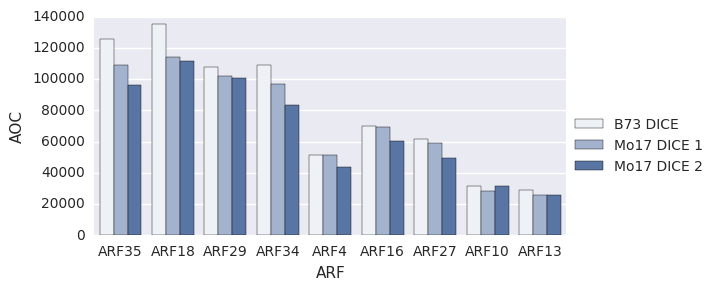

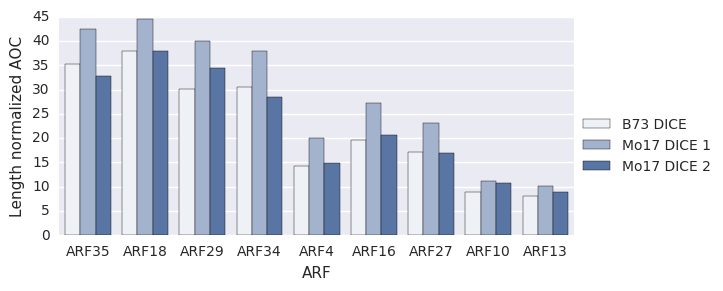

In [5]:
#Calculating and plotting area under the curve:
AOC = Calculate_area_under_curve_for_relative_positional_arf_binding(relative_positional_arf_binding)

fig = seaborn.FacetGrid(data=AOC,aspect =2)
fig.map(seaborn.barplot,'ARF','AOC','Sequence label').add_legend()
fig.savefig('/mnt/Data_DapSeq_Maize/170705_SNP_Relative_ARF_binding_AOC.svg')

fig = seaborn.FacetGrid(data=AOC,aspect =2)
fig.map(seaborn.barplot,'ARF','Length normalized AOC','Sequence label').add_legend()
fig.savefig('/mnt/Data_DapSeq_Maize/170705_SNP_Relative_ARF_binding_length_normalized_AOC.svg')



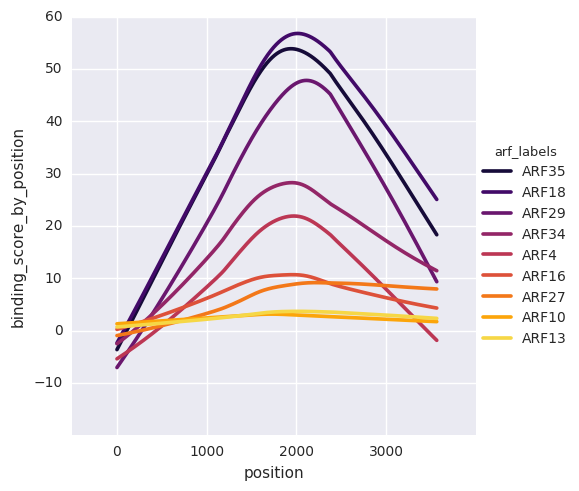

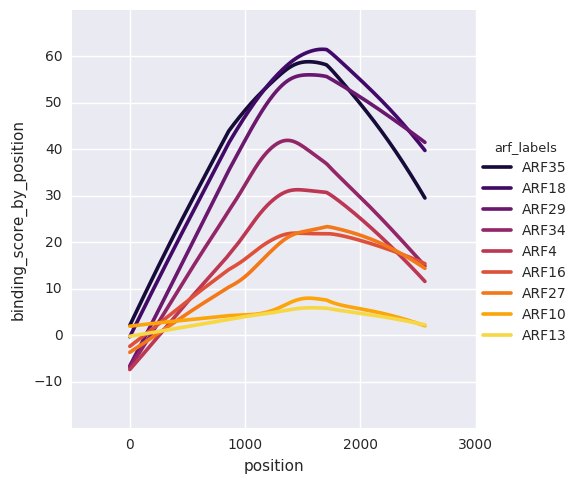

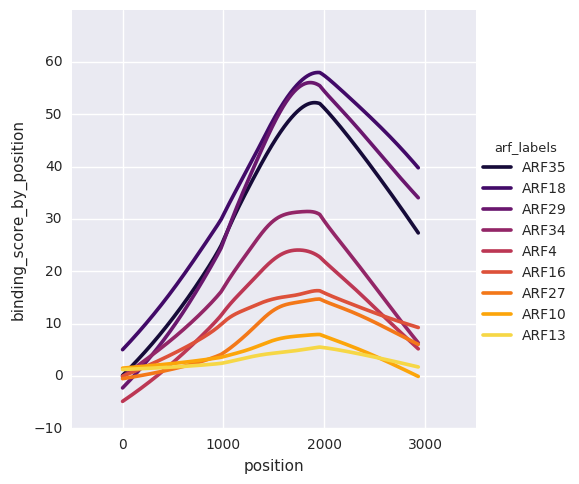

In [6]:
#Plotting analysis on the indeviual DICE elements with just the activator ARFs
fig = seaborn.lmplot(data =relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']=='B73 DICE'],x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True)
plt.yticks(numpy.arange(-10, 70, 10))
plt.xticks(numpy.arange(0, 3600, 1000))
fig.savefig('/mnt/Data_DapSeq_Maize/170705_SNP_Relative_ARF_binding_B73_DICE.svg')

fig = seaborn.lmplot(data =relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']=='Mo17 DICE 1'],x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True)
plt.yticks(numpy.arange(-10, 70, 10))
plt.xticks(numpy.arange(0, 3600, 1000))
fig.savefig('/mnt/Data_DapSeq_Maize/170705_SNP_Relative_ARF_binding_Mo17_DICE_1.svg')

fig = seaborn.lmplot(data =relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']=='Mo17 DICE 2'],x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True)
plt.yticks(numpy.arange(-10, 70, 10))
plt.xticks(numpy.arange(0, 3600, 1000))
fig.savefig('/mnt/Data_DapSeq_Maize/170705_SNP_Relative_ARF_binding_Mo17_DICE_2.svg')


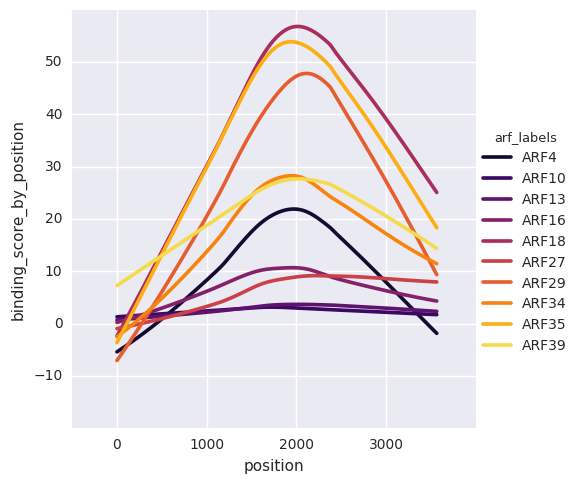

In [31]:
seaborn.lmplot(data=relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==0], x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True)
plt.xticks(numpy.arange(0, 3566, 1000))
plt.yticks(numpy.arange(-10, 60, 10))
plt.savefig('/mnt/Data_DapSeq_Maize/170609_SNP_Relative_ARF_binding_analysis_B73V44.svg')

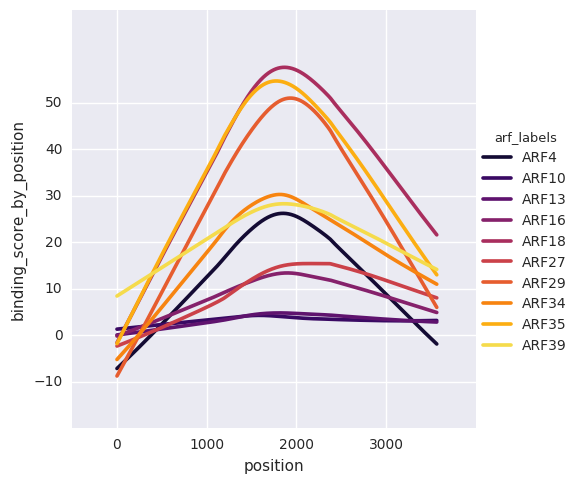

In [32]:
seaborn.lmplot(data=relative_positional_arf_binding[(relative_positional_arf_binding['sequence_label']==1)&(relative_positional_arf_binding['position']<3566)], x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True)
plt.xticks(numpy.arange(0, 3566, 1000))
plt.yticks(numpy.arange(-10, 60, 10))
plt.savefig('/mnt/Data_DapSeq_Maize/170609_SNP_Relative_ARF_binding_analysis_Mo17_tuncated.svg')

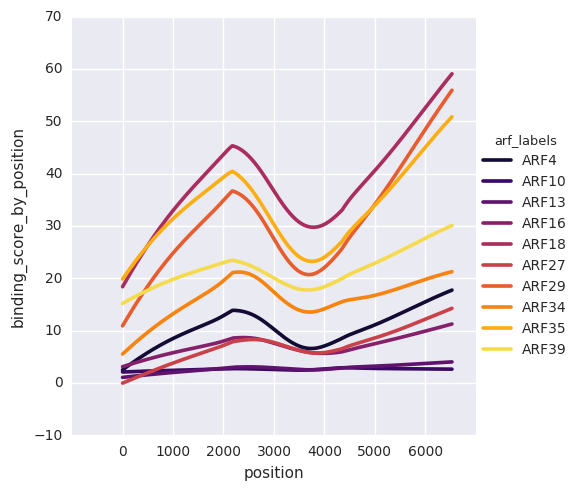

In [13]:
seaborn.lmplot(data=relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==1], x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True)
plt.xticks(numpy.arange(min(relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==1]['position']), max(relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==1]['position'])+1, 1000.0))
plt.savefig('/mnt/Data_DapSeq_Maize/170609_SNP_Relative_ARF_binding_analysis_Mo17.svg')

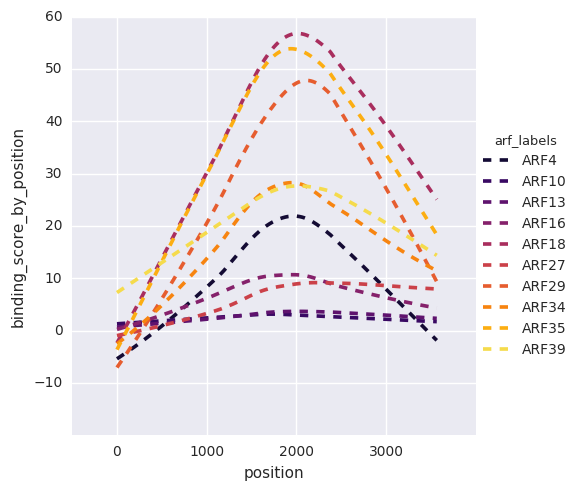

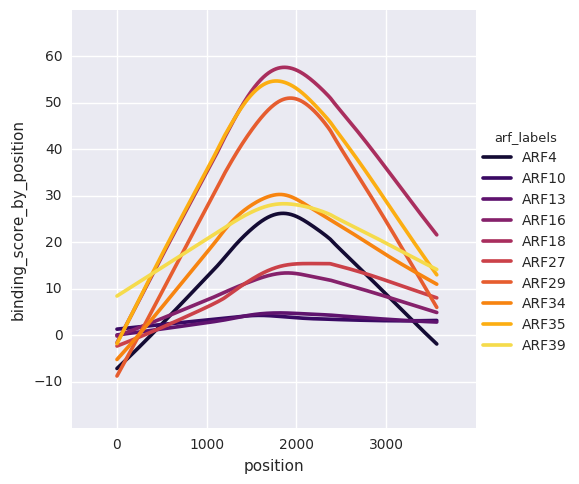

In [47]:
lm = seaborn.lmplot(data=relative_positional_arf_binding[relative_positional_arf_binding['sequence_label']==0], x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True,line_kws={'linestyle': '--'})
lm.set(xticks = numpy.arange(0, 3566, 1000) )
lm.set(yticks = numpy.arange(-10, 70, 10) )
plt.savefig('/mnt/Data_DapSeq_Maize/170609_SNP_Relative_ARF_binding_analysis_B73V44_for_comparison.svg')
lm2 = seaborn.lmplot(data=relative_positional_arf_binding[(relative_positional_arf_binding['sequence_label']==1)&(relative_positional_arf_binding['position']<3566)], x='position',y='binding_score_by_position',hue='arf_labels',palette='inferno',scatter=False,lowess=True,line_kws={'linestyle': '-'})
lm2.set(xticks = numpy.arange(0, 3566, 1000) )
lm2.set(yticks = numpy.arange(-10, 70, 10) )
plt.savefig('/mnt/Data_DapSeq_Maize/170609_SNP_Relative_ARF_binding_analysis_Mo17_for_comparison.svg')

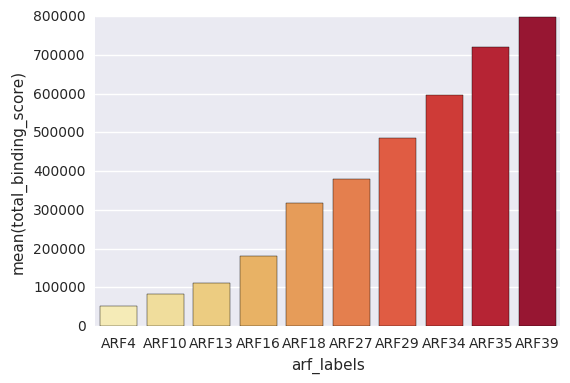

In [19]:
seaborn.barplot(data=relative_total_arf_binding[relative_total_arf_binding['sequence_label']==0],x='arf_labels',y='total_binding_score',palette='YlOrRd')
plt.savefig('/mnt/Data_DapSeq_Maize/170609_SNP_Total_ARF_binding_analysis_B73V44.svg')

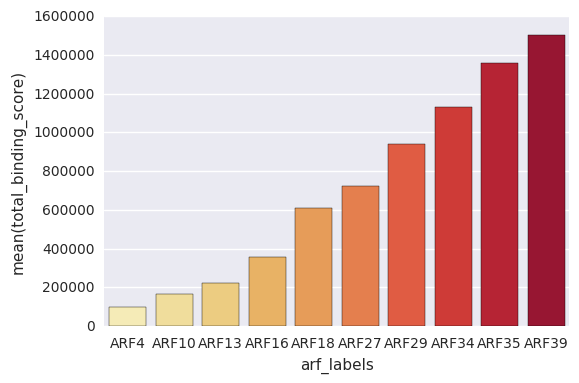

In [24]:
seaborn.barplot(data=relative_total_arf_binding[relative_total_arf_binding['sequence_label']==10],x='arf_labels',y='total_binding_score',palette='YlOrRd')
plt.savefig('/mnt/Data_DapSeq_Maize/170609_SNP_Total_ARF_binding_analysis_Mo17.svg')